In [1]:
source_code = """ #BPMN simulation diagram
def check_ast(node, parent=None, color = "black"):
    if isinstance(node, ast.Module):
        for child in ast.iter_child_nodes(node):
            return check_ast(child)
    if isinstance(node, ast.FunctionDef):
        graph.node(f"Start▷- {node.name}", fixedsize = "True", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        parent = f"Start▷- {node.name}"

        parallel = check_sub_tree_parallelism(node)
        children = []
        for i in range(len(parallel.values())):
            if i == 0:
                if len(parallel.values()) > 1:
                    if list(parallel.values())[i+1] == True:
                        # open + and add as child of that
                        graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                        graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                        parent = f"Start+- {str(node)}"
                        children.append(check_ast(node.body[i], parent))
                    if list(parallel.values())[i+1] == False:
                        # add as child of start and set parent to new node
                        sub_tree_parent = parent
                        parent = check_ast(node.body[i], sub_tree_parent)
            else:
                if list(parallel.values())[i] == True:
                    if list(parallel.values())[i-1] == True:
                        # add as child of previous + or create new one
                        if "Start+-" in str(parent):
                            children.append(check_ast(node.body[i], parent))
                        else:
                            graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                            # graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                            parent = f"Start+- {str(node)}"
                            children.append(check_ast(node.body[i], parent))
                    if list(parallel.values())[i-1] == False:
                        # close + and add as child of that
                        graph.node(f"End+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                        children.append(check_ast(node.body[i], parent))
                        for child in children:
                            graph.edge(str(child), f"End+- {str(node)}", color = color)
                        children = []
                        parent = f"End+- {str(node)}"
                if list(parallel.values())[i] == False:
                    if list(parallel.values())[i-1] == False:
                        # add as child of previous
                        sub_tree_parent = parent
                        parent = check_ast(node.body[i], sub_tree_parent)
                    if list(parallel.values())[i-1] == True:
                        if children != []:
                            # close + and add as child of that
                            graph.node(f"End+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                            for child in children:
                                graph.edge(str(child), f"End+- {str(node)}", color = color)
                            children = []
                            parent = f"End+- {str(node)}"
                            sub_tree_parent = parent
                            parent = check_ast(node.body[i], sub_tree_parent)
                        else:
                            if list(parallel.values())[i+1] == True:
                                # open + and add as child of that
                                print("hi")
                                graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                                graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                                parent = f"Start+- {str(node)}"
                                children.append(check_ast(node.body[i], parent))
                            if list(parallel.values())[i+1] == False:
                                # add as child of start and set parent to new node
                                sub_tree_parent = parent
                                parent = check_ast(node.body[i], sub_tree_parent)

        # TODO Check adding last node (must be acylcic graph)
        graph.node("End⃞", fixedsize = "True", label = "⃞", shape = "circle", fontsize = "8", height = "0.5")
        for child in children:
            if "Start" not in str(child):
                graph.edge(str(child), str("End⃞"))
        else: 
            if "Start" not in str(parent):
                graph.edge(str(parent), str("End⃞"))
    if isinstance(node, ast.If):
        sub_tree_children = [] # Calls in the test node
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        if node.orelse != []:
            # Exclusive
            graph.node(f"Start×- {str(node)}", fixedsize = "True", label = "×", shape = "diamond", width = "0.5", height = "0.5")
            if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Start×- {str(node)}", color = color)
            else:
                graph.edge(str(parent), f"Start×- {str(node)}", color = color)
            parent = f"Start×- {str(node)}"
            children = []
            for child in node.body:
                children.append(check_ast(child, parent, color = "cyan2"))
            for child in node.orelse:
                children.append(check_ast(child, parent, color = "cyan4"))
            graph.node(f"End×- {str(node)}", fixedsize = "True", label = "×", shape = "diamond", width = "0.5", height = "0.5")
            # if len(children) > 1:
            #     color = "red"
            # else:
            color = "black"
            for child in children:
                if isinstance(child, ast.Call) or True or "End×-" in str(child):
                    graph.edge(str(child), f"End×- {str(node)}", color = color)
                parent = f"End×- {str(node)}"
            return parent
        else:
            # Inclusive
            graph.node(f"Start○- {str(node)}", fixedsize = "True", label = "○", shape = "diamond", width = "0.5", height = "0.5")
            if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Start○- {str(node)}")
            else:
                graph.edge(str(parent), f"Start○- {str(node)}")
            parent = f"Start○- {str(node)}"
            children = []
            for child in node.body:
                children.append(check_ast(child, parent, color = "cyan2"))
            graph.node(f"End○- {str(node)}", fixedsize = "True", label = "○", shape = "diamond", width = "0.5", height = "0.5")
            # if len(children) > 1:
            #     color = "red"
            # else:
            color = "black"
            for child in children:
                if isinstance(child, ast.Call) or True or "End○-" in str(child):
                    graph.edge(str(child), f"End○- {str(node)}", color = color)
                parent = f"End○- {str(node)}"
            return parent
    if isinstance(node, ast.For):
        sub_tree_children = [] # Calls in the test node
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        graph.node(f"Starf- {str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        if sub_tree_children != []:
            for child in sub_tree_children:
                graph.edge(str(child), f"Starf- {str(node)}")
        else:
            graph.edge(str(parent), f"Starf- {str(node)}", color = color)
        parent = f"Starf- {str(node)}"
        children = []
        for child in node.body:
            children.append(check_ast(child, parent, color = "cyan2"))
        for child in node.orelse:
            children.append(check_ast(child, parent, color = "cyan4"))
        graph.node(f"Endf-{str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        for child in children:
            if "Start" not in str(child):
                graph.edge(str(child), f"Endf-{str(node)}")
        parent = f"Endf-{str(node)}"
        return parent
    if isinstance(node, ast.While):
        sub_tree_children = [] # Calls in the test node
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        graph.node(f"Startw- {str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Startw- {str(node)}", color = color)
        else:
            graph.edge(str(parent), f"Startw- {str(node)}", color = color)
        parent = f"Startw- {str(node)}"
        children = []
        for child in node.body:
            children.append(check_ast(child, parent, color = "cyan2"))
        for child in node.orelse:
            children.append(check_ast(child, parent, color = "cyan4"))
        graph.node(f"Endw-{str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        for child in children:
            print(str(child))
            print("Start" in str(child))
            if "Start" not in str(child):
                graph.edge(str(child), f"Endw-{str(node)}")
        parent = f"Endw-{str(node)}"
        return parent
    if isinstance(node, ast.Call):
        # Parallel
        graph.node(str(node), label = get_func_name(node.func))
        graph.edge(str(parent), str(node), color = color)
        parent = node
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent, color)
    if isinstance(node, ast.Assign):
        calls = get_calls(node.value)
        for call in calls:
            return check_ast(call, parent, color)
        else:
            if parent:
                return parent
    else:
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent, color)
        else:
            if parent:
                return parent
"""

In [16]:
source_code = """ # Comment
def test():
    start_time = datetime.today().replace(
        tzinfo=None,
        microsecond=0) - timedelta(days=100)
    end_time = datetime.today().replace(microsecond=0)
"""

In [17]:
import ast
import astor
ast_tree = ast.parse(source_code)
res = ast.dump(ast_tree, indent=4)
for line in res.split("\n"):
    print(line)

Module(
    body=[
        FunctionDef(
            name='test',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='start_time', ctx=Store())],
                    value=BinOp(
                        left=Call(
                            func=Attribute(
                                value=Call(
                                    func=Attribute(
                                        value=Name(id='datetime', ctx=Load()),
                                        attr='today',
                                        ctx=Load()),
                                    args=[],
                                    keywords=[]),
                                attr='replace',
                                ctx=Load()),
                            args=[],
    

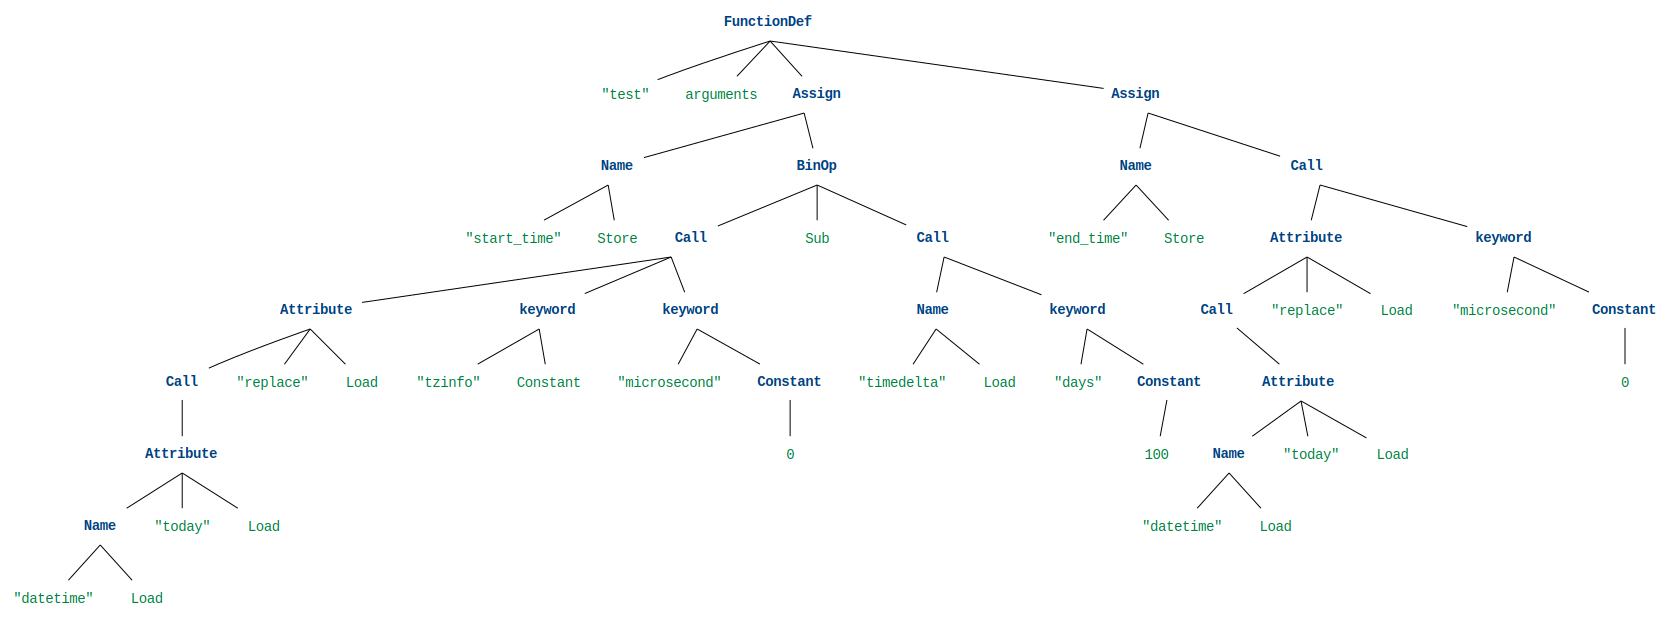

In [18]:
from showast import showast
showast("jo", ast.parse(source_code))

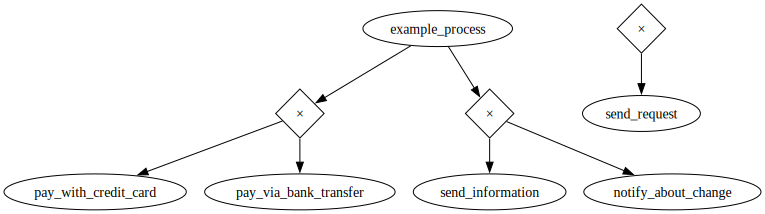

In [7]:
# Visit methods and colour them according to how they can be executed, in 
# parallel, based on condition (invlusvive vs. excluseive)
from turtle import width
from graphviz import Digraph, escape, render
from scipy.__config__ import show

graph = Digraph()
parents = []

def visit(node, parent=None):
    global parents
    if isinstance(node, ast.FunctionDef):
        if parent is None:
            graph.node(str(node), label = node.name)
        else:
            graph.node(str(node), label = node.name)
            graph.edge(str(parent), str(node))
            parents.append(parent)
        parent = node
    
    elif isinstance(node, ast.Call):
        func_name = get_func_name(node.func)
        if isinstance(parent, ast.If):
            graph.node(str(node), label = func_name)
            graph.edge(str(parent), str(node))
            parents.append(node)
        elif isinstance(parent, ast.FunctionDef) and parents == []:
            graph.node(str(node), label = func_name)
            parent = "END-IF" + str(node)
            graph.node(parent, label = "×", shape = "diamond", width = "0.1", height = "0.1")
            for parent_node in parents:
                if not isinstance(parent_node, ast.If):
                    graph.edge(str(parent_node), parent)
            graph.edge(str(parent), str(node))
            parents = []
        elif "END-IF" in str(parent):
            graph.edge(str(parent), str(node))
            parents.append(node)
        # else:
            # graph.node(str(node), label = func_name)
            # graph.edge(str(parent), func_name)
            # parents = []
    elif isinstance(node, ast.If) and not isinstance(parent, ast.If): # Exclusive
        graph.node(str(node), label = "×", shape = "diamond", width = "0.1", height = "0.1")
        graph.edge(str(parent), str(node))
        parent = node
        parents.append(node)
    elif isinstance(node, ast.If): # Parallel
        graph.node(str(node), label = "+", shape = "diamond", width = "0.1", height = "0.1")
        graph.edge(str(parent), str(node))
        parent = node
        parents.append(node)
    for child in ast.iter_child_nodes(node):
        visit(child, parent)

def get_func_name(node):
    if isinstance(node, ast.Name):
        return node.id
    elif isinstance(node, ast.Attribute):
        return f"{get_func_name(node.value)}.{node.attr}"
    else:
        return ""

visit(ast_tree)
display(graph)
# graph.render("Exports/test", format="pdf")


In [10]:
def get_variables(node):
    variables = dict()
    if isinstance(node, ast.Assign):
        for target in node.targets:
            if isinstance(target, ast.Name):
                variables.setdefault("store", set()).add(target.id)
    if isinstance(node, ast.Compare):
        for expression in node.comparators:
            if isinstance(expression, ast.Name):
                variables.setdefault("load", set()).add(expression.id)
        if not isinstance(node.left, ast.Constant) and isinstance(node.left, ast.Name):
            variables.setdefault("load", set()).add(node.left.id)
    if isinstance(node, ast.Call):
        for arg in node.args:
            if isinstance(arg, ast.Name):
                variables.setdefault("load", set()).add(arg.id)
        for keyword in node.keywords:
            variables.setdefault("load", set()).add(keyword.arg)
    if isinstance(node, ast.If):
        if isinstance(node.test, ast.Name):
            variables.setdefault("load", set()).add(node.test.id)
    for child in ast.iter_child_nodes(node):
        res = get_variables(child)
        if "load" in res.keys():
            for variable in res["load"]:
                variables.setdefault("load", set()).add(variable)
        if "store" in res.keys():
            for variable in res["store"]:
                variables.setdefault("store", set()).add(variable)
    return variables

In [6]:
def check_sub_tree_parallelism(node):
    """ Returns a dictionary of type {node: {store: [], load: []}}
        i.e. variables stored and loaded for each direct child node of the passed AST """
    variables = {}
    for child in ast.iter_child_nodes(node):
        variables[child] = get_variables(child)
    parallel = {}
    current_dependent_variables = []
    for sub_tree in list(variables.keys())[1:]:
        if "store" in variables[sub_tree].keys():
            for variable in variables[sub_tree]["store"]:
                current_dependent_variables.append(variable)
        parallel[sub_tree] = True
        if "load" in variables[sub_tree].keys():
            for variable in variables[sub_tree]["load"]:
                if variable in current_dependent_variables:
                    parallel[sub_tree] = False
                    current_dependent_variables = []
                    if "store" in variables[sub_tree].keys():
                        for variable in variables[sub_tree]["store"]:
                            current_dependent_variables.append(variable)
                    break        
    return parallel

In [5]:
def get_func_name(node):
    if isinstance(node, ast.Name):
        return node.id
    elif isinstance(node, ast.Attribute):
        return f"{get_func_name(node.value)}.{node.attr}"
    elif isinstance(node, ast.FunctionDef):
        return node.name
    else:
        return ""

In [19]:
def check_sub_tree(node, sub_tree_parent=None):
    print(node)
    if isinstance(node, ast.If) and node.orelse != []:
        for child in node.body:
            exclusive_execution(child, node)
        for child in node.orelse:
            exclusive_execution(child, node)
    elif isinstance(node, ast.If) and node.orelse == []:
        for child in node.body:
            inclusive_execution(child, node)
    else:
        pass
    
def parallel_execution(head, parent):
    global _parent
    count = 0
    for _ in ast.iter_child_nodes(head):
        count += 1
    to_close = set()
    if not _parent:
        graph.node("Start", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        parent = "Start"
    def _parallel_execution(node):
        global parent
        if count > 1 and parent and "p-" not in str(parent):  # TODO Potential bug
            graph.node("p-" + str(node), label = "×", shape = "diamond", fontsize = "8", width = "0.5", height = "0.5")
            graph.edge(str(parent), "p-" + str(node))
            parent = "p-" + str(node)
        if isinstance(node, ast.Call):
            graph.node(str(node), label = get_func_name(node.func))
            graph.edge(str(parent), str(node))
            to_close.add(str(node))
        for child in ast.iter_child_nodes(node):
            check_sub_tree(child)

    _parallel_execution(head)

    if len(to_close) > 1:
        graph.node(f"p-End-{str(head)}", label = "×", shape = "diamond", fontsize = "8", width = "0.5", height = "0.5")
        for node in to_close:
            graph.edge(str(node), f"p-End-{str(head)}")
        parent = f"p-End-{str(head)}"
    elif len(to_close) == 1:   
        parent = list(to_close)[0]

def exclusive_execution(head, parent):
    global _parent
    to_close = set()
    if not parent:
        graph.node("Start", label="▷", shape="circle", fontsize="8", height="0.5")
        parent = "Start"
    def _exclusive_execution(node):
        if parent and "e-" not in str(parent): # TODO Potential bug
            graph.node("e-" + str(node), label="+", shape="diamond", fontsize="8", width="0.5", height="0.5")
            graph.edge(str(parent), "e-" + str(node))
            parent = "e-" + str(node)
        if isinstance(node, ast.If) and node.orelse != []:
            # TODO Separate inside funciton def functionality to analyse subtree again
            for child in ast.iter_child_nodes(node.body):
                check_sub_tree(child)
            for child in ast.iter_child_nodes(node.orelse):
                check_sub_tree(child)
        if isinstance(node, ast.Call):
            graph.node(str(node), label=get_func_name(node.func))
            graph.edge(str(parent), str(node))
            to_close.add(str(node))
        for child in ast.iter_child_nodes(node):
            check_sub_tree(child)

    _exclusive_execution(head)

    graph.node(f"e-End{str(head)}", label="+", shape="diamond", fontsize="8", width="0.5", height="0.5")
    for node in to_close:
        graph.edge(str(node), f"e-End{str(head)}")
    parent = f"e-End{str(head)}"

def inclusive_execution(head, parent):
    global _parent
    to_close = set()
    if not _parent:
        graph.node("Start", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        _parent = "Start"
    def _inclusive_execution(node, sub_tree_parent):
        nonlocal parent
        if parent and "i-" not in str(parent):
            graph.node("i-" + str(node), label = "○", shape = "diamond", fontsize = "8", width = "0.5", height = "0.5")
            graph.edge(str(_parent), "i-" + str(node))
            parent = "i-" + str(node)
        if isinstance(node, ast.Call):
            graph.node(str(node), label = get_func_name(node.func))
            graph.edge(str(parent), str(node))
            to_close.add(str(node))
        for child in ast.iter_child_nodes(node):
            check_sub_tree(child, sub_tree_parent)

    _inclusive_execution(head, parent)

    graph.node(f"i-End-{str(head)}", label = "○", shape = "diamond", fontsize = "8", width = "0.5", height = "0.5")
    for node in to_close:
        graph.edge(str(node), f"i-End-{str(head)}")
    parent = f"i-End-{str(head)}"

def sequence_execution(head, parent):
    global _parent
    if not _parent:
        graph.node("Start", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        parent = "Start"
    def _sequence_execution(node):
        # if parent and "s-" not in parent:
        #     graph.node("s-" + str(node), label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        #     graph.edge(parent, "s-" + str(node))
        #     parent = "s-" + str(node)
        if isinstance(node, ast.Call):
            graph.node(str(node), label = get_func_name(node.func))
            if "Start" in str(parent):
                graph.edge(parent, str(node), label = parent.split("-")[1])
            parent = node
        for child in ast.iter_child_nodes(node):
            _sequence_execution(child)

    _sequence_execution(head)
    

    # graph.node(f"s-End-{str(head)}", label = "→", shape = "circle", fontsize = "8", height = "0.5")
    # graph.edge(str(parent), f"s-End-{str(head)}")
    # parent = f"s-End-{str(head)}"

from graphviz import Digraph
_parent = None
graph = Digraph()

def visit_calls(node):
    global _parent
    if isinstance(node, ast.Module):
        for child in ast.iter_child_nodes(node):
            visit_calls(child)
    if isinstance(node, ast.FunctionDef):
        graph.node(f"Start - {node.name}", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        _parent = f"Start - {node.name}"
        dependencies = {}
        for child in node.body:
            dependencies[child] = check_dependencies(child, get_variables(child))
            if "Store: " in str(dependencies[child]):
                sequence_execution(child)
            else:
                check_sub_tree(child)
                
        """ for k, v in dependencies.items():
            print(f"K: {k}, V: {v}")
            for item in dependencies:
            print(dependencies[item]) """

        if "Start" not in "".join([element for element in graph.body]):
            graph.edge(f"Start - {node.name}", str(node), label = parent.split("-")[1]) # TODO Position label correctly
            _parent = node
    variables = set(get_variables(node))

    if len(variables) > 0:
        dependencies = check_dependencies(node, variables)
        visit_later = []
        for child in ast.iter_child_nodes(node):
            if not dependencies.get(str(child)):
                sequence_execution(child)
            else:
                visit_later.append(child)
    else:
        check_sub_tree(node)

def check_dependencies(node, variables):
    dependencies = {}
    for id in ast.iter_child_nodes(node):
        for variable in variables:
            if variable in get_variables(node):
                dependencies.setdefault(str(id), set()).add(variable)
    return dependencies

visit_calls(ast_tree)
graph.node("End", label = "⃞", shape = "circle", fontsize = "8", height = "0.5")
graph.edge(str(_parent), str("End"))
parent = "End"

display(graph)

UnboundLocalError: cannot access local variable 'parent' where it is not associated with a value

In [8]:
def nodes(graph: Digraph):
    return [line for line in graph.body if not "->" in line]

In [3]:
def get_calls(node):
    calls = []
    if isinstance(node, ast.Call):
        calls.append(node)
    for child in ast.iter_child_nodes(node):
        calls += get_calls(child)
    return calls

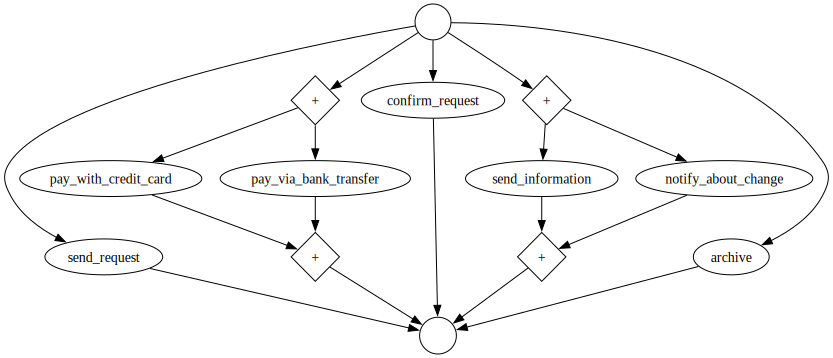

In [ ]:
import re
from graphviz import Digraph
from requests import get
graph = Digraph(strict=True)
graph.clear()

def check_ast(node, parent=None):
    if isinstance(node, ast.Module):
        for child in ast.iter_child_nodes(node):
            return check_ast(child)
    if isinstance(node, ast.FunctionDef):
        graph.node(f"Start▷- {node.name}", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        parent = f"Start▷- {node.name}"
        children = []
        for child in node.body:
            children.append(check_ast(child, parent))
        graph.node("End⃞", label = "⃞", shape = "circle", fontsize = "8", height = "0.5")
        for child in children:
            graph.edge(str(child), str("End⃞"))
    if isinstance(node, ast.If):
        sub_tree_children = []
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent))
        if node.orelse != []:
            # Exclusive
            graph.node(f"Start+- {str(node)}", label = "+", shape = "diamond", width = "0.1", height = "0.1")
            if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Start+- {str(node)}")
            else:
                graph.edge(str(parent), f"Start+- {str(node)}")
            parent = f"Start+- {str(node)}"
            children = []
            for child in node.body:
                children.append(check_ast(child, parent))
            for child in node.orelse:
                children.append(check_ast(child, parent))
            graph.node(f"End+- {str(node)}", label = "+", shape = "diamond", width = "0.1", height = "0.1")
            for child in children:
                # if isinstance(child, ast.Call) or "End○-" in str(child):
                graph.edge(str(child), f"End+- {str(node)}")
                parent = f"End+- {str(node)}"
            return parent
        else:
            # Inclusive
            print(len(sub_tree_children), parent)
            # Test opening nodes
            if len(graph.body) > 1 and "○" in graph.body[-2]:
                for start in reversed(nodes(graph)):
                    if start and "○" in str(start):
                        parent = str(start).split('"')[1].replace("End○- ", "Start○- ")
                        break
                # Action opening nodes
                if sub_tree_children != []:
                    for child in sub_tree_children:
                        graph.edge(str(child), parent)
            else:
                graph.node(f"Start○- {str(node)}", label = "○", shape = "diamond", width = "0.1", height = "0.1")
                if sub_tree_children != []:
                    for child in sub_tree_children:
                        graph.edge(str(parent), str(child))
                        graph.edge(str(child), f"Start○- {str(node)}")
                else:
                    graph.edge(str(parent), f"Start○- {str(node)}")
                parent = f"Start○- {str(node)}"

            children = []
            for child in node.body:
                children.append(check_ast(child, parent))

            # Test closing nodes
            closing_inclusive_nodes = []
            for line in reversed(nodes(graph)):
                if "End○-" in str(line):
                    closing_inclusive_nodes.append(str(line).split('"')[1])
                    break
            # Action closing nodes
            if len(closing_inclusive_nodes) < 1:
                graph.node(f"End○- {str(node)}", label = "○", shape = "diamond", width = "0.1", height = "0.1")
                for child in children:
                    graph.edge(str(child), f"End○- {str(node)}")
                parent = f"End○- {str(node)}"
            else:
                for child in children:
                    graph.edge(str(child), closing_inclusive_nodes[0])
                parent = closing_inclusive_nodes[0]
            return parent
    if isinstance(node, ast.Call):
        # Parallel
        graph.node(str(node), label = get_func_name(node.func))
        graph.edge(str(parent), str(node))
        parent = node
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent)
        else:
            if parent:
                return parent
    if isinstance(node, ast.Assign):
        calls = get_calls(node.value)
        for call in calls:
            return check_ast(call, parent)
        else:
            if parent:
                return parent
    else:
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent)
        else:
            if parent:
                return parent

check_ast(ast_tree)
display(graph)

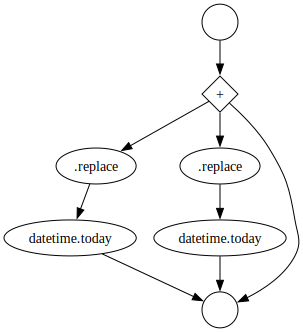

In [19]:
import re
from graphviz import Digraph
from pyparsing import col
from requests import get
graph = Digraph(strict=True)
graph.clear()

def check_ast(node, parent=None, color = "black"):
    if isinstance(node, ast.Module):
        for child in ast.iter_child_nodes(node):
            return check_ast(child)
    if isinstance(node, ast.FunctionDef):
        graph.node(f"Start▷- {node.name}", fixedsize = "True", label = "▷", shape = "circle", fontsize = "8", height = "0.5")
        parent = f"Start▷- {node.name}"

        parallel = check_sub_tree_parallelism(node)
        children = []
        for i in range(len(parallel.values())):
            if i == 0:
                if len(parallel.values()) > 1:
                    if list(parallel.values())[i+1] == True:
                        # open + and add as child of that
                        graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                        graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                        parent = f"Start+- {str(node)}"
                        children.append(check_ast(node.body[i], parent))
                    if list(parallel.values())[i+1] == False:
                        # add as child of start and set parent to new node
                        sub_tree_parent = parent
                        parent = check_ast(node.body[i], sub_tree_parent)
                else:
                    # add as child of start
                    parent = check_ast(node.body[i], parent)
            else:
                if list(parallel.values())[i] == True:
                    if list(parallel.values())[i-1] == True:
                        # add as child of previous + or create new one
                        if "Start+-" in str(parent):
                            children.append(check_ast(node.body[i], parent))
                        else:
                            graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                            # graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                            parent = f"Start+- {str(node)}"
                            children.append(check_ast(node.body[i], parent))
                    if list(parallel.values())[i-1] == False:
                        # close + and add as child of that
                        graph.node(f"End+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                        children.append(check_ast(node.body[i], parent))
                        for child in children:
                            graph.edge(str(child), f"End+- {str(node)}", color = color)
                        children = []
                        parent = f"End+- {str(node)}"
                if list(parallel.values())[i] == False:
                    if list(parallel.values())[i-1] == False:
                        # add as child of previous
                        sub_tree_parent = parent
                        parent = check_ast(node.body[i], sub_tree_parent)
                    if list(parallel.values())[i-1] == True:
                        if children != []:
                            # close + and add as child of that
                            graph.node(f"End+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                            for child in children:
                                graph.edge(str(child), f"End+- {str(node)}", color = color)
                            children = []
                            parent = f"End+- {str(node)}"
                            sub_tree_parent = parent
                            parent = check_ast(node.body[i], sub_tree_parent)
                        else:
                            if list(parallel.values())[i+1] == True:
                                # open + and add as child of that
                                graph.node(f"Start+- {str(node)}", fixedsize = "True", label = "+", shape = "diamond", width = "0.5", height = "0.5")
                                graph.edge(str(parent), f"Start+- {str(node)}", color = color)
                                parent = f"Start+- {str(node)}"
                                children.append(check_ast(node.body[i], parent))
                            if list(parallel.values())[i+1] == False:
                                # add as child of start and set parent to new node
                                sub_tree_parent = parent
                                parent = check_ast(node.body[i], sub_tree_parent)

        # TODO Check adding last node (must be acylcic graph)
        graph.node("End⃞", fixedsize = "True", label = "⃞", shape = "circle", fontsize = "8", height = "0.5")
        for child in children:
            graph.edge(str(child), str("End⃞"))
        else: 
            graph.edge(str(parent), str("End⃞"))
    if isinstance(node, ast.If):
        sub_tree_children = [] # Calls in the test node
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        if node.orelse != []:
            # Exclusive
            graph.node(f"Start×- {str(node)}", fixedsize = "True", label = "×", shape = "diamond", width = "0.5", height = "0.5")
            if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Start×- {str(node)}", color = color)
            else:
                graph.edge(str(parent), f"Start×- {str(node)}", color = color)
            parent = f"Start×- {str(node)}"
            children = []
            for child in node.body:
                children.append(check_ast(child, parent, color = "cyan2"))
            for child in node.orelse:
                children.append(check_ast(child, parent, color = "cyan4"))
            graph.node(f"End×- {str(node)}", fixedsize = "True", label = "×", shape = "diamond", width = "0.5", height = "0.5")
            # if len(children) > 1:
            #     color = "red"
            # else:
            color = "black"
            for child in children:
                if "Start×" not in str(child) or len(children) < 2:# if isinstance(child, ast.Call) or True or "End×-" in str(child):
                    graph.edge(str(child), f"End×- {str(node)}", color = color)
                parent = f"End×- {str(node)}"
            return parent
        else:
            # Inclusive
            graph.node(f"Start○- {str(node)}", fixedsize = "True", label = "○", shape = "diamond", width = "0.5", height = "0.5")
            if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Start○- {str(node)}")
            else:
                graph.edge(str(parent), f"Start○- {str(node)}")
            parent = f"Start○- {str(node)}"
            children = []
            for child in node.body:
                children.append(check_ast(child, parent, color = "cyan2"))
            graph.node(f"End○- {str(node)}", fixedsize = "True", label = "○", shape = "diamond", width = "0.5", height = "0.5")
            # if len(children) > 1:
            #     color = "red"
            # else:
            color = "black"
            for child in children:
                if "Start○" not in str(child) or len(children) < 2:#if isinstance(child, ast.Call) or True or "End○-" in str(child):
                    graph.edge(str(child), f"End○- {str(node)}", color = color)
                parent = f"End○- {str(node)}"
            return parent
    if isinstance(node, ast.For):
        sub_tree_children = [] # Calls in the test node
        if node.target:
            calls = get_calls(node.target)
            calls += get_calls(node.iter)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        graph.node(f"Starf- {str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        if sub_tree_children != []:
            for child in sub_tree_children:
                graph.edge(str(child), f"Starf- {str(node)}")
        else:
            graph.edge(str(parent), f"Starf- {str(node)}", color = color)
        parent = f"Starf- {str(node)}"
        children = []
        for child in node.body:
            children.append(check_ast(child, parent, color = "cyan2"))
        for child in node.orelse:
            children.append(check_ast(child, parent, color = "cyan4"))
        graph.node(f"Endf-{str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        for child in children:
            if "Startf" not in str(child) or len(children) < 2:
                graph.edge(str(child), f"Endf-{str(node)}")
        parent = f"Endf-{str(node)}"
        return parent
    if isinstance(node, ast.While):
        sub_tree_children = [] # Calls in the test node
        if node.test:
            calls = get_calls(node.test)
            for call in calls:
                sub_tree_children.append(check_ast(call, parent, color = "red"))
        graph.node(f"Startw- {str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        if sub_tree_children != []:
                for child in sub_tree_children:
                    graph.edge(str(child), f"Startw- {str(node)}", color = color)
        else:
            graph.edge(str(parent), f"Startw- {str(node)}", color = color)
        parent = f"Startw- {str(node)}"
        children = []
        for child in node.body:
            children.append(check_ast(child, parent, color = "cyan2"))
        for child in node.orelse:
            children.append(check_ast(child, parent, color = "cyan4"))
        graph.node(f"Endw-{str(node)}", fixedsize = "True", label = "⟲", shape = "diamond", width = "0.5", height = "0.5")
        for child in children:
            if "Startw" not in str(child) or len(children) < 2:
                graph.edge(str(child), f"Endw-{str(node)}")
        parent = f"Endw-{str(node)}"
        return parent
    if isinstance(node, ast.Call):
        # Parallel
        graph.node(str(node), label = get_func_name(node.func))
        graph.edge(str(parent), str(node), color = color)
        parent = node
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent, color)
    if isinstance(node, ast.Assign):
        calls = get_calls(node.value)
        for call in calls:
            return check_ast(call, parent, color)
        else:
            if parent:
                return parent
    else:
        for child in ast.iter_child_nodes(node):
            return check_ast(child, parent, color)
        else:
            if parent:
                return parent

check_ast(ast_tree)

display(graph)


In [ ]:
graph.clear()
parent = None
parallel_execution(ast_tree)
display(graph)

In [ ]:
# Visit methods and colour them according to how they can be executed, in 
# parallel, based on condition (invlusvive vs. excluseive)
from turtle import width
from graphviz import Digraph

graph = Digraph()
parents = []

def visit(node, parent=None):
    global parents
    if isinstance(node, ast.FunctionDef):
        if parent is None:
            graph.node(str(node), label = node.name)
        else:
            graph.node(str(node), label = node.name)
            graph.edge(str(parent), str(node))
            parents.append(parent)
        parent = node
    
    elif isinstance(node, ast.Call):
        func_name = get_func_name(node.func)
        if isinstance(parent, ast.If):
            graph.node(str(node), label = func_name)
            graph.edge(str(parent), str(node))
            parents.append(node)
        elif isinstance(parent, ast.FunctionDef) and parents == []:
            graph.node(str(node), label = func_name)
            parent = "END-IF" + str(node)
            graph.node(parent, label = "×", shape = "diamond", width = "0.1", height = "0.1")
            for parent_node in parents:
                if not isinstance(parent_node, ast.If):
                    graph.edge(str(parent_node), parent)
            graph.edge(str(parent), str(node))
            parents = []
        elif "END-IF" in str(parent):
            graph.edge(str(parent), str(node))
            parents.append(node)
        # else:
            # graph.node(str(node), label = func_name)
            # graph.edge(str(parent), func_name)
            # parents = []
    elif isinstance(node, ast.If) and not isinstance(parent, ast.If): # Exclusive
        graph.node(str(node), label = "×", shape = "diamond", width = "0.1", height = "0.1")
        graph.edge(str(parent), str(node))
        parent = node
        parents.append(node)
    elif isinstance(node, ast.If): # Parallel
        graph.node(str(node), label = "+", shape = "diamond", width = "0.1", height = "0.1")
        graph.edge(str(parent), str(node))
        parent = node
        parents.append(node)
    direct_children = ast.iter_child_nodes(node)
    # check_interdependency(direct_children)

In [ ]:
visit(ast_tree)
display(graph)
# graph.render("Exports/test", format="pdf")

In [14]:
from pylint.lint import Run

results = Run(['main.py'], exit=False)
# `exit` is deprecated, use `do_exit` instead
print(results.linter.stats.global_note)

************* Module main
main.py:30:63: C0303: Trailing whitespace (trailing-whitespace)
main.py:36:0: C0303: Trailing whitespace (trailing-whitespace)
main.py:42:5: W0511: TODO Delete the repo after all analysis has been performed (only for production) (fixme)
main.py:1:0: C0114: Missing module docstring (missing-module-docstring)
main.py:10:0: C0116: Missing function or method docstring (missing-function-docstring)
main.py:30:36: C0207: Use repo_url.rsplit('/', maxsplit=1)[-1] instead (use-maxsplit-arg)
main.py:33:46: C0207: Use repo_url.rsplit('/', maxsplit=1)[-1] instead (use-maxsplit-arg)
main.py:40:4: W0612: Unused variable 'pulls' (unused-variable)

------------------------------------------------------------------
Your code has been rated at 6.52/10 (previous run: 6.52/10, +0.00)

6.521739130434783
